In [1]:
import numpy as np
from dataclasses import dataclass

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer

def mee(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if y_true.ndim != 2 or y_pred.ndim != 2 or y_true.shape[1] != 4 or y_pred.shape[1] != 4:
        raise ValueError(f"Expected (n,4). Got y_true={y_true.shape}, y_pred={y_pred.shape}")
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

neg_mee = make_scorer(mee, greater_is_better=False)  # score = -MEE

def split_dev_internal(X, y, test_size=0.2, random_state=42):
    X_dev, X_int, y_dev, y_int = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=True
    )
    print("Dev     :", X_dev.shape, y_dev.shape)
    print("Internal:", X_int.shape, y_int.shape)
    return X_dev, X_int, y_dev, y_int

def make_cv5(random_state=42):
    return KFold(n_splits=5, shuffle=True, random_state=random_state)

@dataclass
class MLPConfig:
    random_state: int = 42
    max_iter: int = 500

    # optimizer
    solver: str = "adam"  # 

    early_stopping: bool = True
    validation_fraction: float = 0.1
    n_iter_no_change: int = 25
    tol: float = 1e-4
    shuffle: bool = True

    # adam params
    learning_rate_init: float = 1e-3
    beta_1: float = 0.9
    beta_2: float = 0.999
    epsilon: float = 1e-8

    # sgd-only 
    learning_rate: str = "adaptive"
    nesterovs_momentum: bool = True

def build_mlp_ttr(cfg: MLPConfig, use_pca=True, pca_components=4):
    x_steps = [("x_scaler", StandardScaler())]
    if use_pca:
        x_steps.append(("pca", PCA(n_components=pca_components, svd_solver="randomized", random_state=cfg.random_state)))

    mlp_kwargs = dict(
        solver=cfg.solver,
        max_iter=cfg.max_iter,
        early_stopping=cfg.early_stopping,
        validation_fraction=cfg.validation_fraction,
        n_iter_no_change=cfg.n_iter_no_change,
        tol=cfg.tol,
        random_state=cfg.random_state,
        shuffle=cfg.shuffle,
        learning_rate_init=cfg.learning_rate_init,
    )

    if cfg.solver == "adam":
        mlp_kwargs.update(dict(beta_1=cfg.beta_1, beta_2=cfg.beta_2, epsilon=cfg.epsilon))
    elif cfg.solver == "sgd":
        mlp_kwargs.update(dict(learning_rate=cfg.learning_rate, nesterovs_momentum=cfg.nesterovs_momentum))

    x_steps.append(("mlp", MLPRegressor(**mlp_kwargs)))
    x_pipe = Pipeline(x_steps)

    model = TransformedTargetRegressor(
        regressor=x_pipe,
        transformer=StandardScaler()
    )
    return model

def run_grid_search(estimator, param_grid, X_dev, y_dev, cv, verbose=1, n_jobs=-1):
    gs = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=neg_mee,
        cv=cv,
        n_jobs=n_jobs,
        refit=True,
        return_train_score=True,
        error_score=np.nan,
        verbose=verbose
    )
    gs.fit(X_dev, y_dev)
    print("Best params:", gs.best_params_)
    print("Best CV MEE :", -gs.best_score_)
    return gs

def eval_internal(best_estimator, X_internal, y_internal):
    y_pred = best_estimator.predict(X_internal)  
    score = mee(y_internal, y_pred)
    print("Internal MEE:", score)
    return score


In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold

def mlp_learning_curve_5fold_cv_mean_only(
    X, y,
    mlp_params,
    epochs=500,
    cv=None,
    random_state=42,
    use_pca=True,
    pca_components=4,
    verbose=False,
    patience=30,   
    min_delta=1e-4,  
    smooth_window=1,  
):
    X = np.asarray(X)
    y = np.asarray(y)

    if cv is None:
        cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    n_folds = cv.get_n_splits()
    train_scores = np.zeros((n_folds, epochs), dtype=float)
    val_scores   = np.zeros((n_folds, epochs), dtype=float)

    for fold_id, (tr_idx, va_idx) in enumerate(cv.split(X, y)):
        if verbose:
            print(f"Fold {fold_id+1}/{n_folds}")

        X_tr, X_va = X[tr_idx], X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        # --- Fit X preprocess on TRAIN fold only ---
        x_scaler = StandardScaler().fit(X_tr)
        X_tr_s = x_scaler.transform(X_tr)
        X_va_s = x_scaler.transform(X_va)

        if use_pca:
            pca = PCA(
                n_components=pca_components,
                svd_solver="randomized",
                random_state=random_state
            ).fit(X_tr_s)
            X_tr_p = pca.transform(X_tr_s)
            X_va_p = pca.transform(X_va_s)
        else:
            X_tr_p, X_va_p = X_tr_s, X_va_s

        # --- Fit y scaler on TRAIN fold only ---
        y_scaler = StandardScaler().fit(y_tr)
        y_tr_s = y_scaler.transform(y_tr)

        # --- Build MLP for epoch-by-epoch training ---
        params = dict(mlp_params)
        params.setdefault("solver", "adam")  # Set solver if not defined

        # Set max_iter to 1 to train epoch by epoch
        params.update({
            "max_iter": 1,
            "warm_start": True,
            "early_stopping": False,  # We control early stopping manually
            "random_state": random_state,
        })

        mlp = MLPRegressor(**params)

        best_val_score = np.inf
        best_epoch = 0
        patience_counter = 0

        # --- Epoch loop ---
        for epoch in range(epochs):
            mlp.fit(X_tr_p, y_tr_s)

            y_tr_pred_s = mlp.predict(X_tr_p)
            y_va_pred_s = mlp.predict(X_va_p)

            if y_tr_pred_s.ndim == 1:
                y_tr_pred_s = y_tr_pred_s.reshape(-1, 1)
            if y_va_pred_s.ndim == 1:
                y_va_pred_s = y_va_pred_s.reshape(-1, 1)

            y_tr_pred = y_scaler.inverse_transform(y_tr_pred_s)
            y_va_pred = y_scaler.inverse_transform(y_va_pred_s)

            train_scores[fold_id, epoch] = mee(y_tr, y_tr_pred)
            val_scores[fold_id, epoch] = mee(y_va, y_va_pred)

            # Early stopping logic: If no improvement for `patience` epochs, stop
            if val_scores[fold_id, epoch] < best_val_score - min_delta:
                best_val_score = val_scores[fold_id, epoch]
                best_epoch = epoch
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1} for fold {fold_id + 1}")
                    break  # Stop early if patience is reached

    return train_scores.mean(axis=0), val_scores.mean(axis=0)


In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold

def mlp_learning_curve_5fold_cv_mean_only(
    X, y,
    mlp_params,
    epochs=500,
    cv=None,
    random_state=42,
    use_pca=True,
    pca_components=4,
    verbose=False
):
    X = np.asarray(X)
    y = np.asarray(y)

    if cv is None:
        cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    n_folds = cv.get_n_splits()
    train_scores = np.zeros((n_folds, epochs), dtype=float)
    val_scores   = np.zeros((n_folds, epochs), dtype=float)

    for fold_id, (tr_idx, va_idx) in enumerate(cv.split(X, y)):
        if verbose:
            print(f"Fold {fold_id+1}/{n_folds}")

        X_tr, X_va = X[tr_idx], X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        # --- Fit X preprocess on TRAIN fold only ---
        x_scaler = StandardScaler().fit(X_tr)
        X_tr_s = x_scaler.transform(X_tr)
        X_va_s = x_scaler.transform(X_va)

        if use_pca:
            pca = PCA(
                n_components=pca_components,
                svd_solver="randomized",
                random_state=random_state
            ).fit(X_tr_s)
            X_tr_p = pca.transform(X_tr_s)
            X_va_p = pca.transform(X_va_s)
        else:
            X_tr_p, X_va_p = X_tr_s, X_va_s

        # --- Fit y scaler on TRAIN fold only ---
        y_scaler = StandardScaler().fit(y_tr)
        y_tr_s = y_scaler.transform(y_tr)

        # --- Build MLP for epoch-by-epoch training ---
        params = dict(mlp_params)

        params.setdefault("solver", "adam")

        params.update({
            "max_iter": 1,
            "warm_start": True,
            "early_stopping": False,
            "random_state": random_state,
        })

        mlp = MLPRegressor(**params)

        # --- Epoch loop ---
        for e in range(epochs):
            mlp.fit(X_tr_p, y_tr_s)

            y_tr_pred_s = mlp.predict(X_tr_p)
            y_va_pred_s = mlp.predict(X_va_p)

            # 2D for inverse_transform
            if y_tr_pred_s.ndim == 1:
                y_tr_pred_s = y_tr_pred_s.reshape(-1, 1)
            if y_va_pred_s.ndim == 1:
                y_va_pred_s = y_va_pred_s.reshape(-1, 1)

            y_tr_pred = y_scaler.inverse_transform(y_tr_pred_s)
            y_va_pred = y_scaler.inverse_transform(y_va_pred_s)

            train_scores[fold_id, e] = mee(y_tr, y_tr_pred)
            val_scores[fold_id, e]   = mee(y_va, y_va_pred)

    return train_scores.mean(axis=0), val_scores.mean(axis=0)

# Phase 1

In [12]:
param_grid_stage1_adam = {
    "regressor__mlp__hidden_layer_sizes": [(32,), (32, 16), (64, 64)],
    "regressor__mlp__batch_size": [256, 128],
    "regressor__mlp__learning_rate_init": [1e-4, 3e-4, 1e-3, 3e-3],
    "regressor__mlp__alpha": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    # optional 
    # "regressor__mlp__beta_1": [0.9, 0.95],
    # "regressor__mlp__beta_2": [0.999, 0.9999],
    # "regressor__mlp__epsilon": [1e-8, 1e-7],
}

In [4]:
import pandas as pd
import numpy as np

def load_cup_clean_csv(path):
    df = pd.read_csv(path)
    X = df.iloc[:, :12].to_numpy(dtype=float)
    y = df.iloc[:, 12:16].to_numpy(dtype=float)  # 4 outputs
    return X, y

# ví dụ:
X, y = load_cup_clean_csv("cup25_train_clean.csv")
print(X.shape, y.shape)  # (n,12) và (n,4)

(500, 12) (500, 4)


In [5]:
X_dev, X_int, y_dev, y_int = split_dev_internal(X, y, test_size=0.2, random_state=42)

Dev     : (400, 12) (400, 4)
Internal: (100, 12) (100, 4)


In [7]:
cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42, solver="adam")
model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1_adam, X_dev, y_dev, cv5, verbose=1)
eval_internal(gs1.best_estimator_, X_int, y_int)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best params: {'regressor__mlp__alpha': 0.01, 'regressor__mlp__batch_size': 128, 'regressor__mlp__hidden_layer_sizes': (64, 64), 'regressor__mlp__learning_rate_init': 0.003}
Best CV MEE : 21.246601435235473
Internal MEE: 20.473285846887958


20.473285846887958

In [6]:
def extract_mlp_params(best_params, prefix="regressor__mlp__"):
    return {k[len(prefix):]: v for k, v in best_params.items() if k.startswith(prefix)}

In [9]:
def extract_mlp_params(best_params, prefix="regressor__mlp__"):
    return {k[len(prefix):]: v for k, v in best_params.items() if k.startswith(prefix)}

MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST["solver"] = "adam"

In [7]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

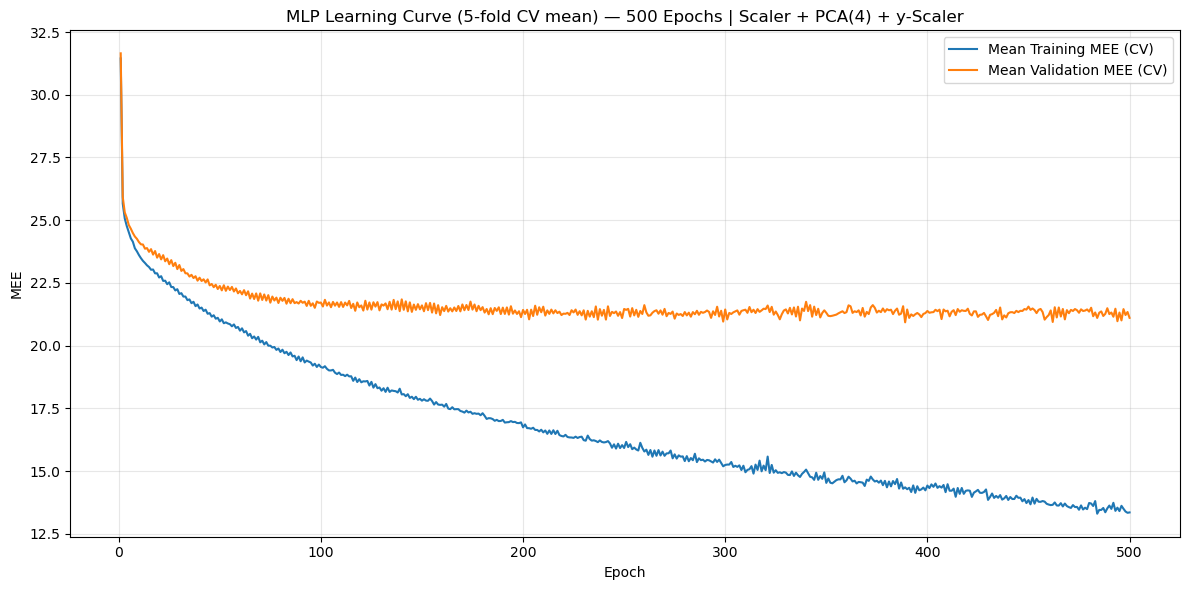

In [15]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()


# phase 2: increase alpha

In [16]:
param_grid_stage1_adam = {
    "regressor__mlp__hidden_layer_sizes": [(32,), (32, 16), (64, 64)],
    "regressor__mlp__batch_size": [256, 128],
    "regressor__mlp__learning_rate_init": [1e-4, 3e-4, 1e-3, 3e-3],
    "regressor__mlp__alpha": [0.01, 0.03, 0.05, 0.1, 0.2, 0.5],
    # optional 
    # "regressor__mlp__beta_1": [0.9, 0.95],
    # "regressor__mlp__beta_2": [0.999, 0.9999],
    # "regressor__mlp__epsilon": [1e-8, 1e-7],
}

In [17]:
cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42, solver="adam")
model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1_adam, X_dev, y_dev, cv5, verbose=1)
eval_internal(gs1.best_estimator_, X_int, y_int)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best params: {'regressor__mlp__alpha': 0.01, 'regressor__mlp__batch_size': 128, 'regressor__mlp__hidden_layer_sizes': (64, 64), 'regressor__mlp__learning_rate_init': 0.003}
Best CV MEE : 21.246601435235473
Internal MEE: 20.473285846887958


20.473285846887958

In [18]:
MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST["solver"] = "adam"

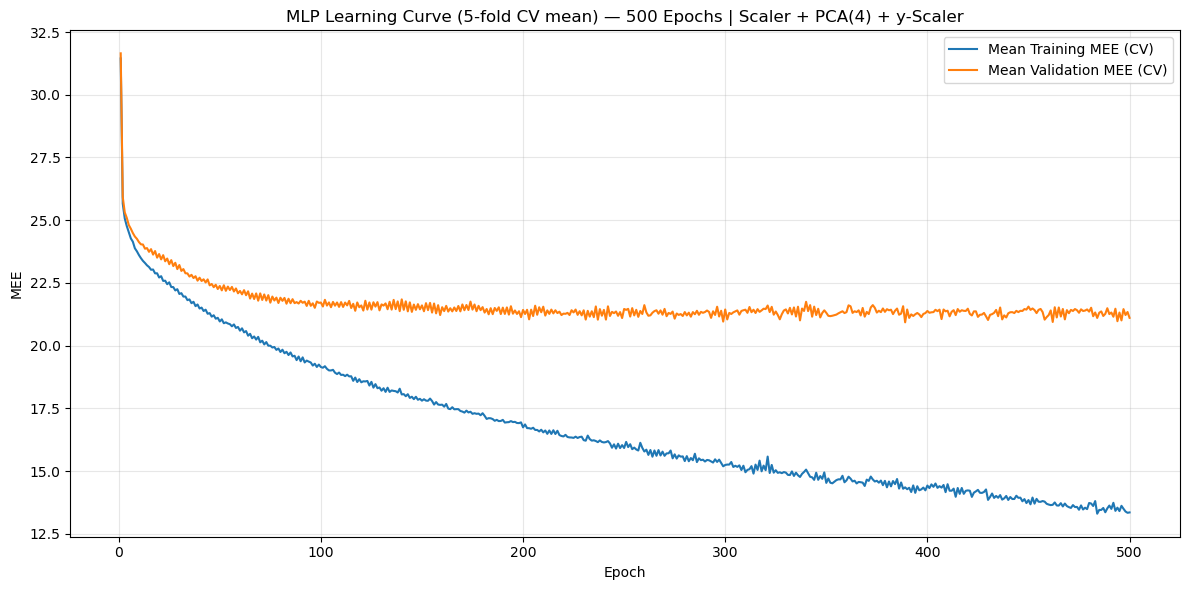

In [19]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()


# phase 3: reduce alpha

In [20]:
param_grid_stage1_adam = {
    "regressor__mlp__hidden_layer_sizes": [(32,), (32, 16), (64, 64)],
    "regressor__mlp__batch_size": [256, 128],
    "regressor__mlp__learning_rate_init": [1e-4, 3e-4, 1e-3, 3e-3],
    "regressor__mlp__alpha": [0.01, 0.003, 0.005],
    # optional 
    # "regressor__mlp__beta_1": [0.9, 0.95],
    # "regressor__mlp__beta_2": [0.999, 0.9999],
    # "regressor__mlp__epsilon": [1e-8, 1e-7],
}

In [21]:
cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42, solver="adam")
model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1_adam, X_dev, y_dev, cv5, verbose=1)
eval_internal(gs1.best_estimator_, X_int, y_int)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'regressor__mlp__alpha': 0.01, 'regressor__mlp__batch_size': 128, 'regressor__mlp__hidden_layer_sizes': (64, 64), 'regressor__mlp__learning_rate_init': 0.003}
Best CV MEE : 21.246601435235473
Internal MEE: 20.473285846887958


20.473285846887958

In [22]:
MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST["solver"] = "adam"

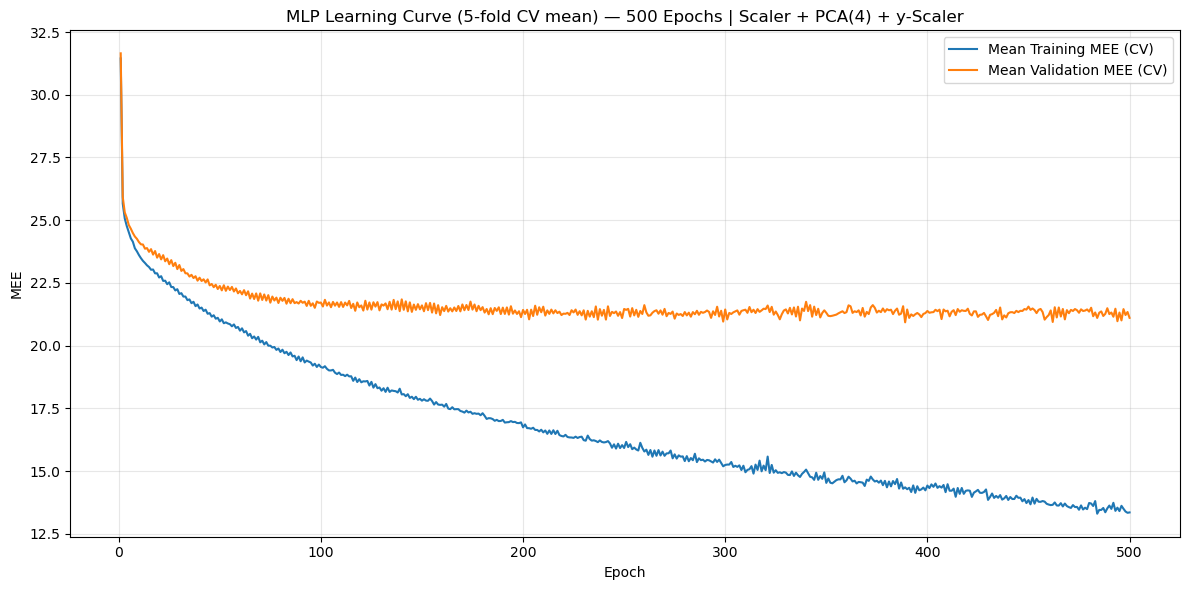

In [23]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()


In [26]:
param_grid_stage1_adam = {
    "regressor__mlp__hidden_layer_sizes": [(64,32), (32, 16), (64, 64)],
    "regressor__mlp__batch_size": [64, 128],
    "regressor__mlp__learning_rate_init": [1e-4, 3e-4, 1e-3, 3e-3],
    "regressor__mlp__alpha": [0.01, 0.003, 0.005],
    # optional 
    # "regressor__mlp__beta_1": [0.9, 0.95],
    # "regressor__mlp__beta_2": [0.999, 0.9999],
    # "regressor__mlp__epsilon": [1e-8, 1e-7],
}

In [27]:
cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42, solver="adam")
model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1_adam, X_dev, y_dev, cv5, verbose=1)
eval_internal(gs1.best_estimator_, X_int, y_int)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'regressor__mlp__alpha': 0.01, 'regressor__mlp__batch_size': 64, 'regressor__mlp__hidden_layer_sizes': (64, 64), 'regressor__mlp__learning_rate_init': 0.003}
Best CV MEE : 21.1797032676454
Internal MEE: 20.27122498251486


20.27122498251486

In [28]:
MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST["solver"] = "adam"

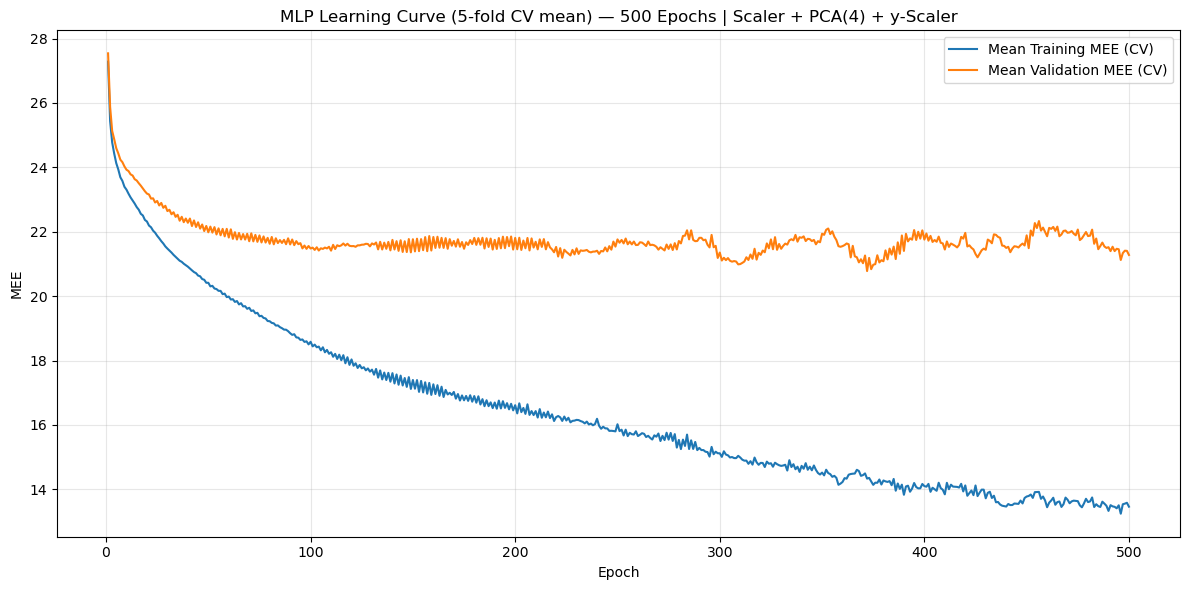

In [29]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()


# phase 4: fix batch at 128

In [30]:
param_grid_stage1_adam = {
    "regressor__mlp__hidden_layer_sizes": [(64,32), (32, 16), (64, 64)],
    "regressor__mlp__batch_size": [128],
    "regressor__mlp__learning_rate_init": [1e-4, 3e-4, 1e-3, 3e-3],
    "regressor__mlp__alpha": [0.03, 0.05],
    # optional 
    # "regressor__mlp__beta_1": [0.9, 0.95],
    # "regressor__mlp__beta_2": [0.999, 0.9999],
    # "regressor__mlp__epsilon": [1e-8, 1e-7],
}

In [31]:
cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42, solver="adam")
model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1_adam, X_dev, y_dev, cv5, verbose=1)
eval_internal(gs1.best_estimator_, X_int, y_int)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'regressor__mlp__alpha': 0.03, 'regressor__mlp__batch_size': 128, 'regressor__mlp__hidden_layer_sizes': (64, 64), 'regressor__mlp__learning_rate_init': 0.003}
Best CV MEE : 21.357588714750637
Internal MEE: 22.07647015533446


22.07647015533446

In [32]:
MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST["solver"] = "adam"

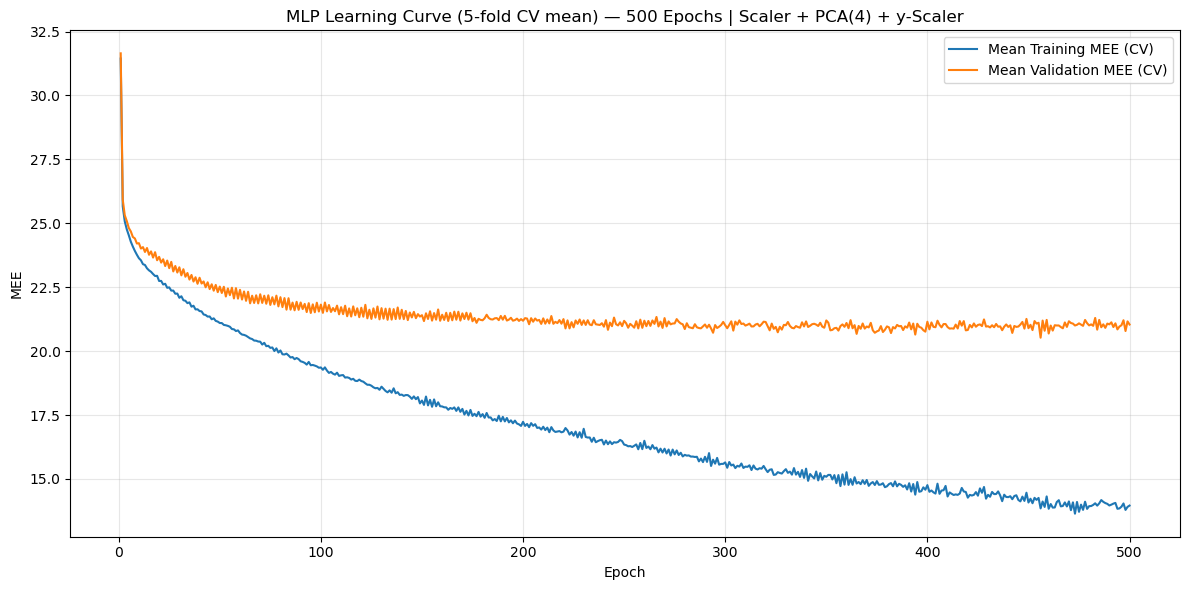

In [33]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()


# phase 6: try to smooth learning curve with new alpha

In [34]:
param_grid_stage1_adam = {
    "regressor__mlp__hidden_layer_sizes": [(64,32), (32, 16), (64, 64)],
    "regressor__mlp__batch_size": [128],
    "regressor__mlp__learning_rate_init": [1e-3, 2e-3, 3e-3, 5e-3],
    "regressor__mlp__alpha": [0.01],
    # optional
    # "regressor__mlp__beta_1": [0.9, 0.95],
    # "regressor__mlp__beta_2": [0.999, 0.9999],
    # "regressor__mlp__epsilon": [1e-8, 1e-7],
}

In [35]:
cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42, solver="adam")
model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1_adam, X_dev, y_dev, cv5, verbose=1)
eval_internal(gs1.best_estimator_, X_int, y_int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'regressor__mlp__alpha': 0.01, 'regressor__mlp__batch_size': 128, 'regressor__mlp__hidden_layer_sizes': (64, 64), 'regressor__mlp__learning_rate_init': 0.003}
Best CV MEE : 21.246601435235473
Internal MEE: 20.473285846887958


20.473285846887958

In [36]:
MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST["solver"] = "adam"

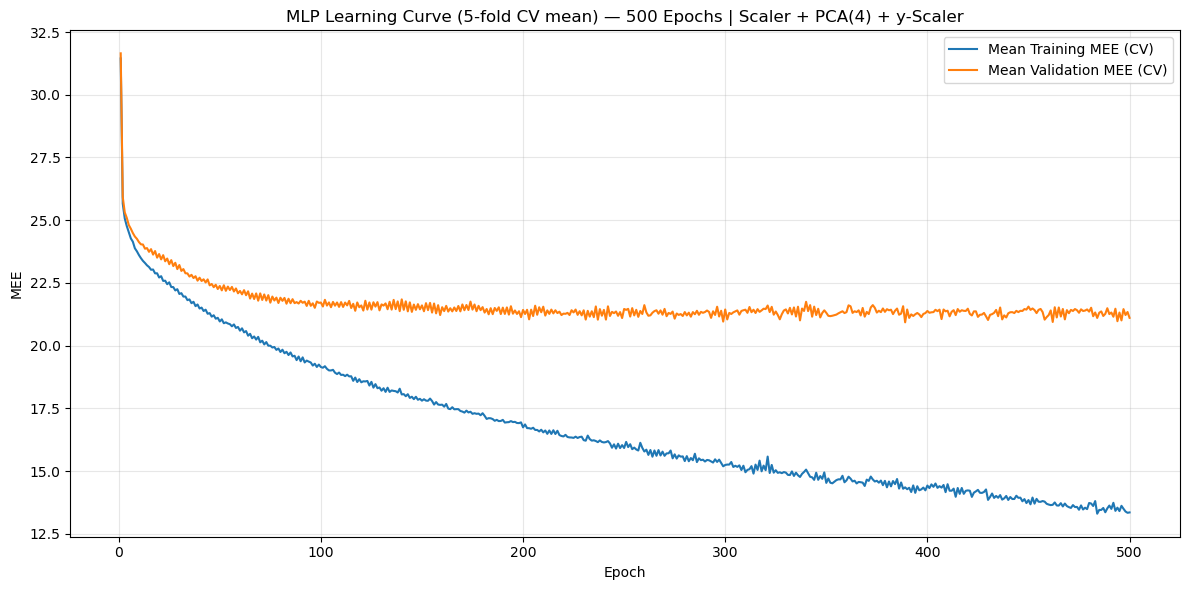

In [37]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()


In [42]:
param_grid_stage1_adam = {
    "regressor__mlp__hidden_layer_sizes": [(128, 64), (128, 64 , 32) ],
    "regressor__mlp__batch_size": [128],
    "regressor__mlp__learning_rate_init": [1e-3, 2e-3, 3e-3, 5e-3],
    "regressor__mlp__alpha": [0.01],
    # optional 
    # "regressor__mlp__beta_1": [0.9, 0.95],
    # "regressor__mlp__beta_2": [0.999, 0.9999],
    # "regressor__mlp__epsilon": [1e-8, 1e-7],
}

In [43]:
cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42, solver="adam")
model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1_adam, X_dev, y_dev, cv5, verbose=1)
eval_internal(gs1.best_estimator_, X_int, y_int)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'regressor__mlp__alpha': 0.01, 'regressor__mlp__batch_size': 128, 'regressor__mlp__hidden_layer_sizes': (128, 64), 'regressor__mlp__learning_rate_init': 0.003}
Best CV MEE : 21.315495923583462
Internal MEE: 20.448755938039337


20.448755938039337

In [44]:
MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST["solver"] = "adam"

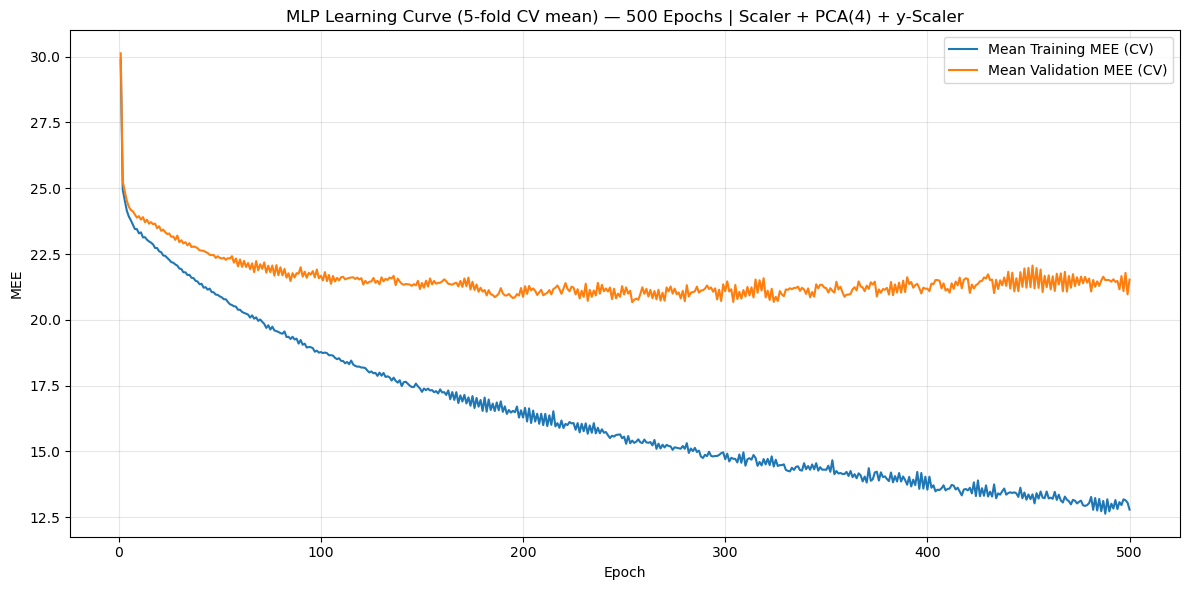

In [45]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()


# phase 7: add 3 layers to test

In [46]:
param_grid_stage1_adam = {
    "regressor__mlp__hidden_layer_sizes": [(128, 64), (128, 64 , 32) ],
    "regressor__mlp__batch_size": [128],
    "regressor__mlp__learning_rate_init": [1e-3, 2e-3],
    "regressor__mlp__alpha": [0.01],
    # optional
    # "regressor__mlp__beta_1": [0.9, 0.95],
    # "regressor__mlp__beta_2": [0.999, 0.9999],
    # "regressor__mlp__epsilon": [1e-8, 1e-7],
}

In [47]:
cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42, solver="adam")
model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1_adam, X_dev, y_dev, cv5, verbose=1)
eval_internal(gs1.best_estimator_, X_int, y_int)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'regressor__mlp__alpha': 0.01, 'regressor__mlp__batch_size': 128, 'regressor__mlp__hidden_layer_sizes': (128, 64), 'regressor__mlp__learning_rate_init': 0.002}
Best CV MEE : 21.85695394306481
Internal MEE: 20.892896858996664


20.892896858996664

In [48]:
MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST["solver"] = "adam"

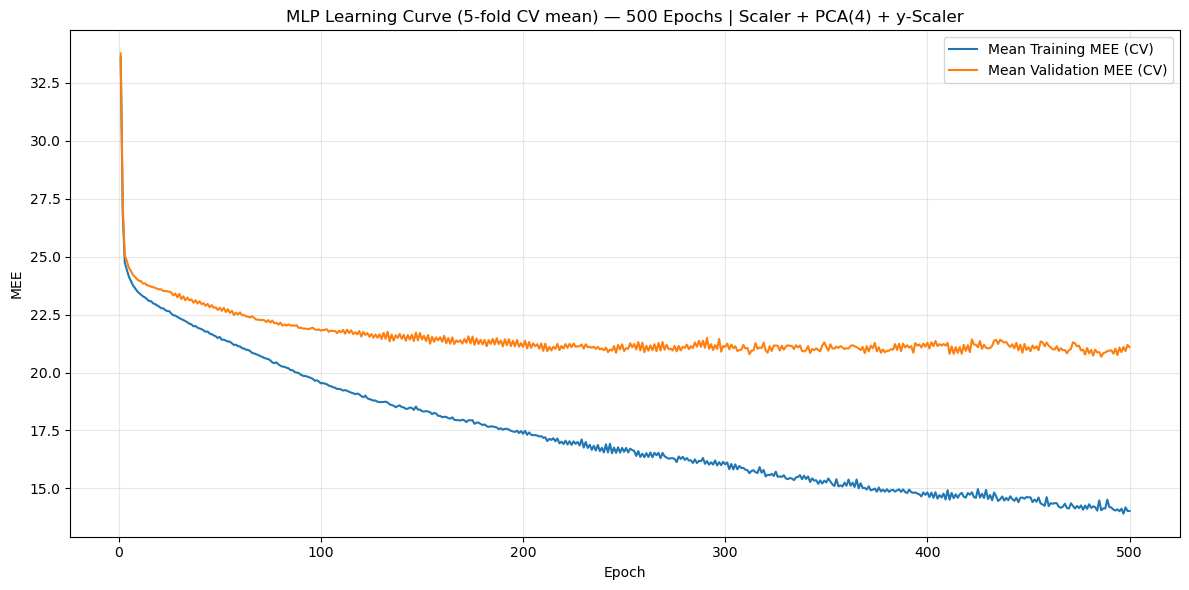

In [49]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()


In [55]:
param_grid_stage1_adam = {
    "regressor__mlp__hidden_layer_sizes": [(128, 64), (128, 64 , 32) ],
    "regressor__mlp__batch_size": [128],
    "regressor__mlp__learning_rate_init": [1e-3, 2e-3],
    "regressor__mlp__alpha": [0.01],
    # optional 
     "regressor__mlp__beta_1": [0.9, 0.95, 0.99],
     "regressor__mlp__beta_2": [0.999, 0.9999],
     "regressor__mlp__epsilon": [1e-8, 1e-7],
}

In [56]:
cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42, solver="adam")
model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1_adam, X_dev, y_dev, cv5, verbose=1)
eval_internal(gs1.best_estimator_, X_int, y_int)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params: {'regressor__mlp__alpha': 0.01, 'regressor__mlp__batch_size': 128, 'regressor__mlp__beta_1': 0.95, 'regressor__mlp__beta_2': 0.9999, 'regressor__mlp__epsilon': 1e-08, 'regressor__mlp__hidden_layer_sizes': (128, 64), 'regressor__mlp__learning_rate_init': 0.002}
Best CV MEE : 21.38243680993128
Internal MEE: 20.23862374494714


20.23862374494714

In [57]:
MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST["solver"] = "adam"

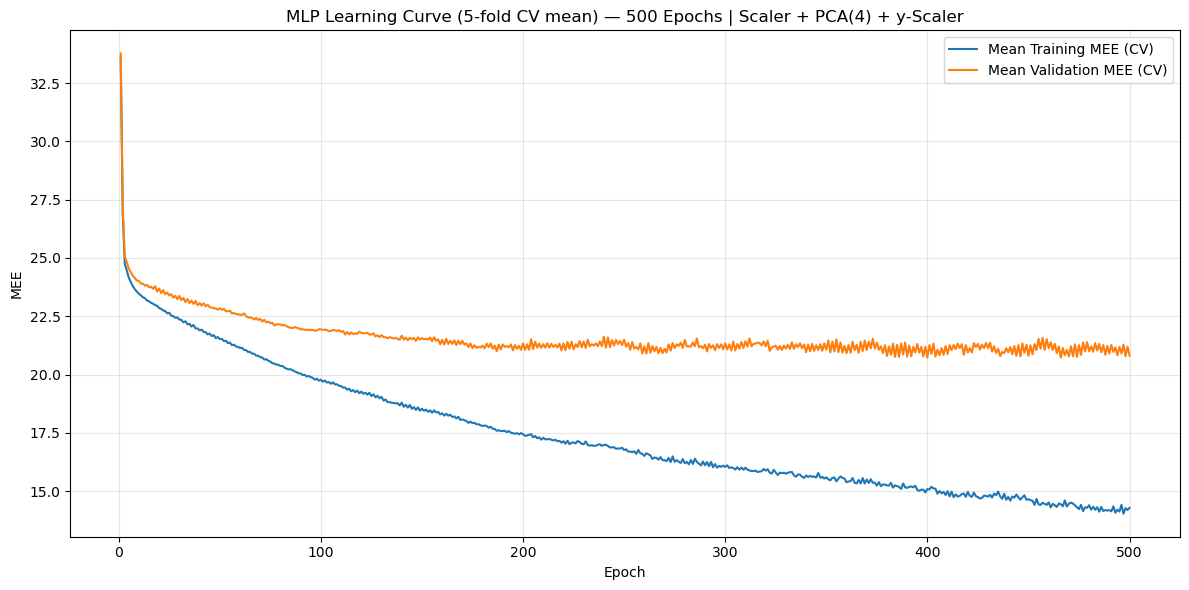

In [58]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()


# phase 8: test with beta1, beta2, epsilon

In [13]:
param_grid_stage1_adam = {
    "regressor__mlp__hidden_layer_sizes": [(128, 64), (128, 64 , 32) ],
    "regressor__mlp__batch_size": [128],
    "regressor__mlp__learning_rate_init": [1e-3, 2e-3],
    "regressor__mlp__alpha": [0.01],

    # optional 
     "regressor__mlp__beta_1": [0.96],
     "regressor__mlp__beta_2": [0.999],
     "regressor__mlp__epsilon": [1e-8, 1e-7],
}

In [14]:
cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42, solver="adam")
model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1_adam, X_dev, y_dev, cv5, verbose=1)
eval_internal(gs1.best_estimator_, X_int, y_int)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'regressor__mlp__alpha': 0.01, 'regressor__mlp__batch_size': 128, 'regressor__mlp__beta_1': 0.96, 'regressor__mlp__beta_2': 0.999, 'regressor__mlp__epsilon': 1e-08, 'regressor__mlp__hidden_layer_sizes': (128, 64), 'regressor__mlp__learning_rate_init': 0.001}
Best CV MEE : 21.633077644865427
Internal MEE: 20.709423223153617


20.709423223153617

In [15]:
MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST["solver"] = "adam"

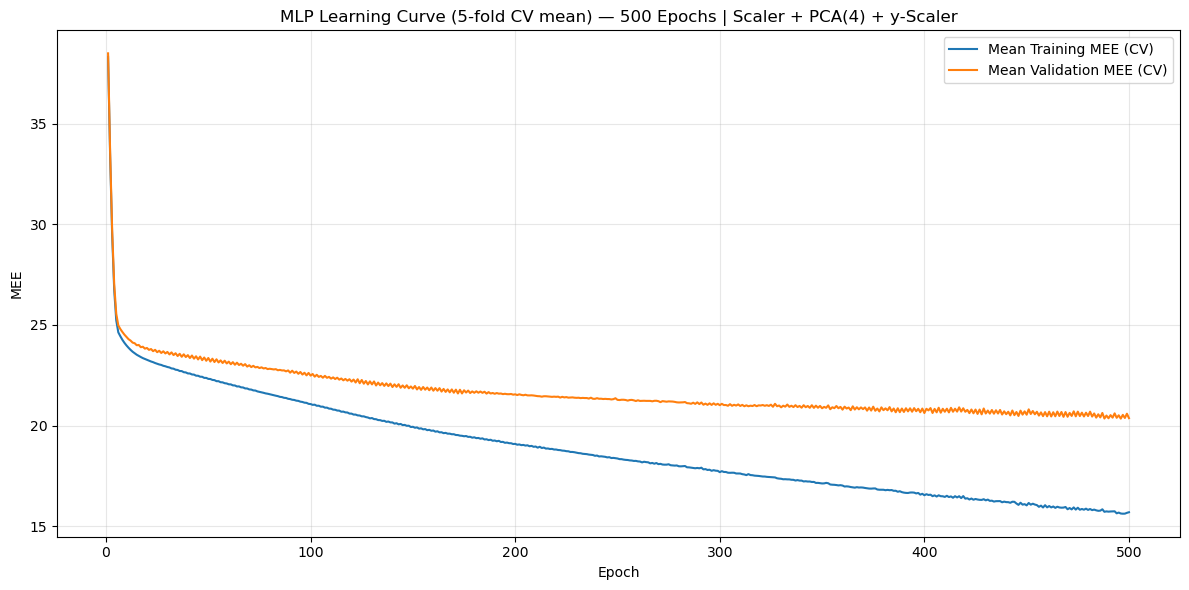

In [16]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()


# phase 9: fix beta1, beta2, epsilo to get best model for adam in scikit learn lib

In [8]:
param_grid_stage1_adam = {
    "regressor__mlp__hidden_layer_sizes": [(128, 64)],
    "regressor__mlp__batch_size": [128],
    "regressor__mlp__learning_rate_init": [1e-3, 2e-3],
    "regressor__mlp__alpha": [0.01],
    "regressor__mlp__activation": ["relu", "tanh"],

    # optional 
     "regressor__mlp__beta_1": [0.96],
     "regressor__mlp__beta_2": [0.999],
     "regressor__mlp__epsilon": [1e-8],
}

In [10]:
cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42, solver="adam")
model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1_adam, X_dev, y_dev, cv5, verbose=1)
eval_internal(gs1.best_estimator_, X_int, y_int)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'regressor__mlp__activation': 'relu', 'regressor__mlp__alpha': 0.01, 'regressor__mlp__batch_size': 128, 'regressor__mlp__beta_1': 0.96, 'regressor__mlp__beta_2': 0.999, 'regressor__mlp__epsilon': 1e-08, 'regressor__mlp__hidden_layer_sizes': (128, 64), 'regressor__mlp__learning_rate_init': 0.001}
Best CV MEE : 21.633077644865427
Internal MEE: 20.709423223153617


20.709423223153617

In [11]:
MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST["solver"] = "adam"

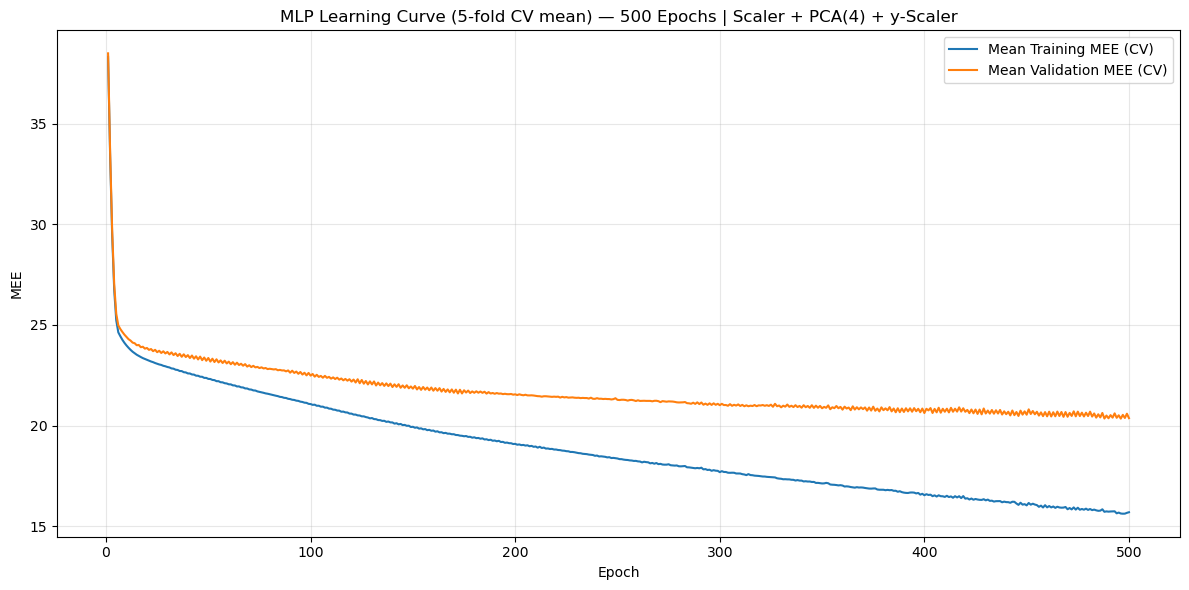

In [12]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()


# Novelty

In Adam, β1 and β2 control the exponential moving averages of the first moment (gradient mean) and second moment (gradient variance), which directly determine the update direction and the adaptive step size at each iteration.

A larger β1 increases momentum smoothing, producing smoother learning curves but potentially slower reaction to new gradient information; this can shift the epoch where validation MEE is minimized and change the selected model.

β2 governs how quickly the algorithm adapts per-parameter learning rates; higher β2 yields more stable scaling (less noisy curves) but can slow convergence, while lower β2 adapts faster but may increase oscillations and reduce generalization.